### Imports & data Directory

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from natsort import natsorted, ns
from skimage import io, color
import math
import natsort
import skimage
import matplotlib.image as img
from matplotlib import markers
from sklearn.svm import LinearSVC
import scipy.misc
from scipy import ndimage
import seaborn as sns
import warnings
from IPython.display import display, HTML

%matplotlib inline

In [2]:
#Directory
data = 'HPTLCRaw\\'
dataTreeLeafEncoding = 'treeLeafEncodingData\\'


# Random Forest For Leaf Encoding

### Grey Scale Import

##### Import Images as Grey Scale

In [3]:
list_files = os.listdir(data)
list_files = natsorted(list_files)
image_list = []
for filename in list_files:
    image_list.append(color.rgb2gray(io.imread(data+filename)[:,:,:3]))

##### Crop all Images

In [4]:
cropped_img_list = []
for image in image_list:
    cropped_img_list.append(image[70:1100,96:-84])

##### Plot Every Cropped File as a Greyscale Image

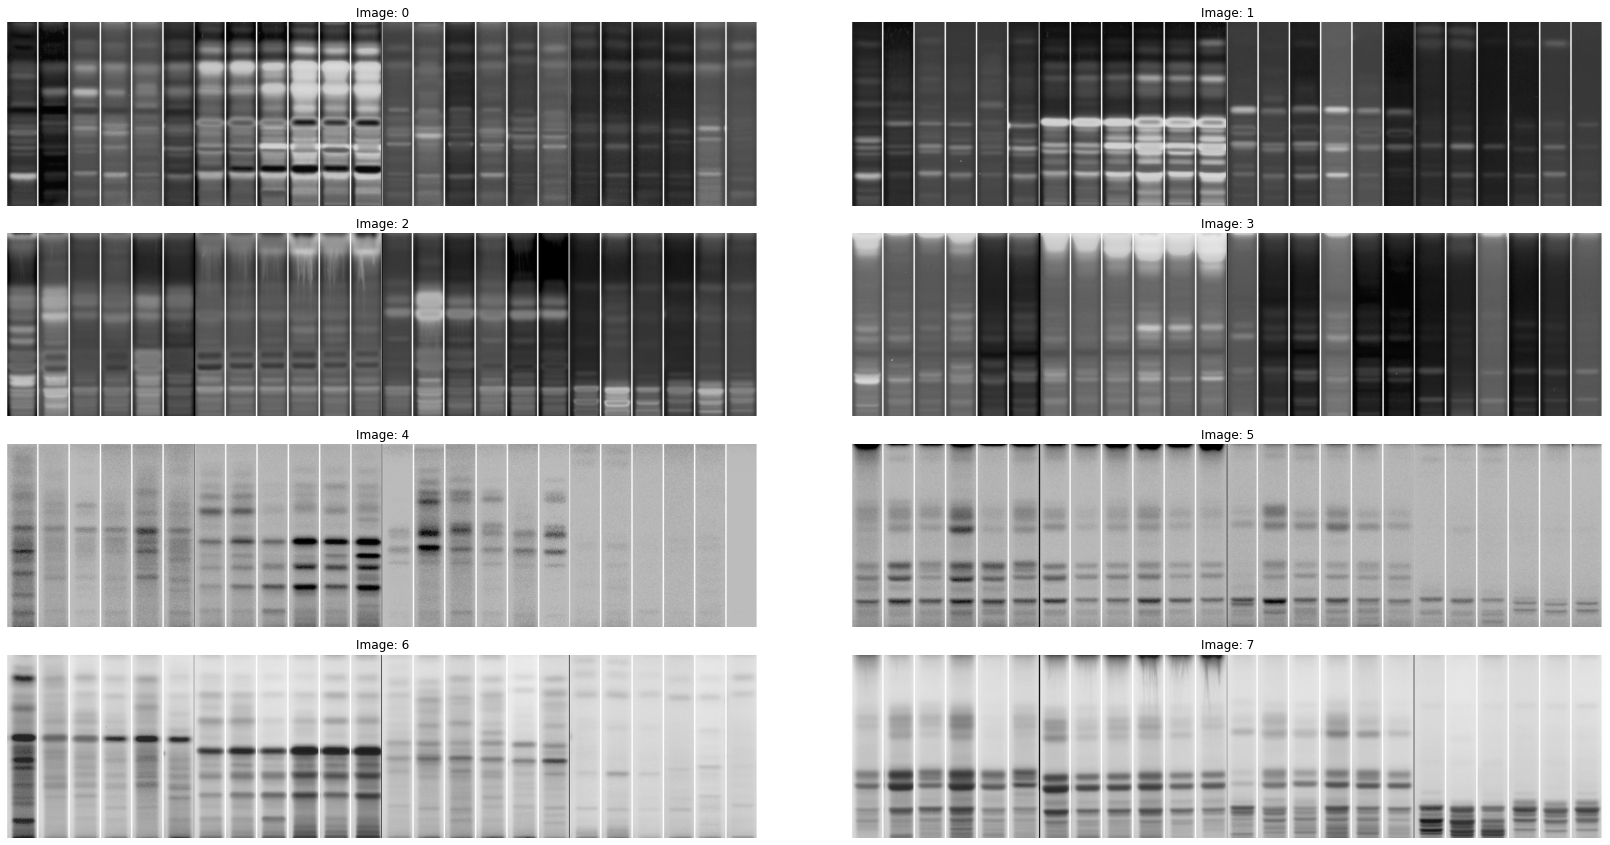

In [5]:
fig = plt.figure(figsize=(30, 15))
for i, img in enumerate(cropped_img_list):
    sub = fig.add_subplot(4, 2, i + 1)
    sub.axis('off')
    sub.imshow(img,cmap='gray')
    sub.set_title('Image: '+str(i))
plt.tight_layout
fig.subplots_adjust(wspace=.02, hspace=.15)

##### Verifying Shape of each Cropped Image


In [6]:
for i in range(len(cropped_img_list)):
    print(np.shape(cropped_img_list[i]))

(1030, 4220)
(1030, 4220)
(1030, 4220)
(1030, 4220)
(1030, 4220)
(1030, 4220)
(1030, 4220)
(1030, 4220)


### Algorithm to determine crop locations

In [7]:
def det_crop_locations(ar):
    maxVal = ar.max()
    res = []
    res.append([0,0])
    n = len(ar)

    i = 10
    while i < len(ar-5):
        # While we are within bounds and
        # we have not found a peak or
        # haven't yet travelled at least 100 pixels or
        # are not within 5% of the max value
        # increment i
        while (i < n-5) and (not (ar[i] >= ar[i-1] and ar[i] >= ar[i+1]) or not (i - res[-1][0] > 100) or not(ar[i] > (.85*maxVal))):
            i += 1

        #if we reach the end of the image, break the loop
        if i >= n-5:
            break

        # Add Back wall of single strip to q
        res[-1][1] = i - 15
        
        #Add front wall to q
        res.append([i + 15,0])
        
    #remove last appended crop as it is at the end of the image and therefore not useful
    res.pop()
    return res

#### Use Function to Determine Crop Locations of Each Image

In [8]:
crops_list = []
for cropped_img in cropped_img_list:
    temp = pd.DataFrame(cropped_img)
    temp_hi_cnt = temp[temp>.8].count()
    temp_low_cnt = temp[temp==0].count()
    temp_cnt = temp_hi_cnt + temp_low_cnt
    crops_list.append(det_crop_locations(temp_cnt.copy()))

In [9]:
# Verify Number of Crops for Each Image
for crops in crops_list:
    print(len(crops))

24
24
24
24
24
24
24
24


##### Generate Plot of Crop Locations for all Images -> Common Sense Check Reasonability of Algorithm Results

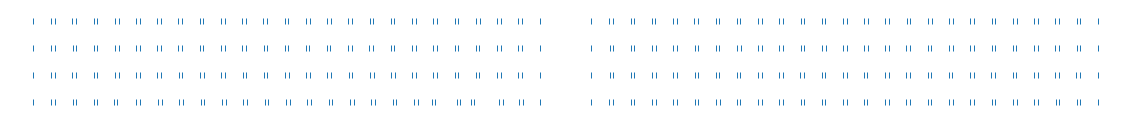

In [10]:
fig = plt.figure(figsize=(20, 2))
for i, crops in enumerate(crops_list):
    temp = pd.DataFrame(crops).to_numpy().flatten()
    sub = fig.add_subplot(4,2,i+1)
    sub.axis('off')
    sub.plot(temp,np.zeros_like(temp),'|')
plt.tight_layout
fig.subplots_adjust(wspace=.001, hspace=0)

##### Cropping Images and adding Individual Slices to new Array

In [11]:
multiview_strip_array = []

#For every View
for i, cropped_image in enumerate(cropped_img_list):
    min_width = float('inf')
    strip_array = []

    #First find the minimum width of all the crops
    for crop in crops_list[i]:
        front, back = crop
        min_width = min(min_width,back-front)

    #Get half of that min width
    min_width_half = int((min_width-2)/2)

    #For each of the crops, crop them from their own midpoint +- the mind_width_half value
    for crop in crops_list[i]:
        front, back = crop
        strip_mid = int(back/2 + front/2)
        min_front = strip_mid - min_width_half
        min_back = min_width_half + strip_mid
        strip_array.append(cropped_image[:,min_front:min_back])

    multiview_strip_array.append(strip_array)

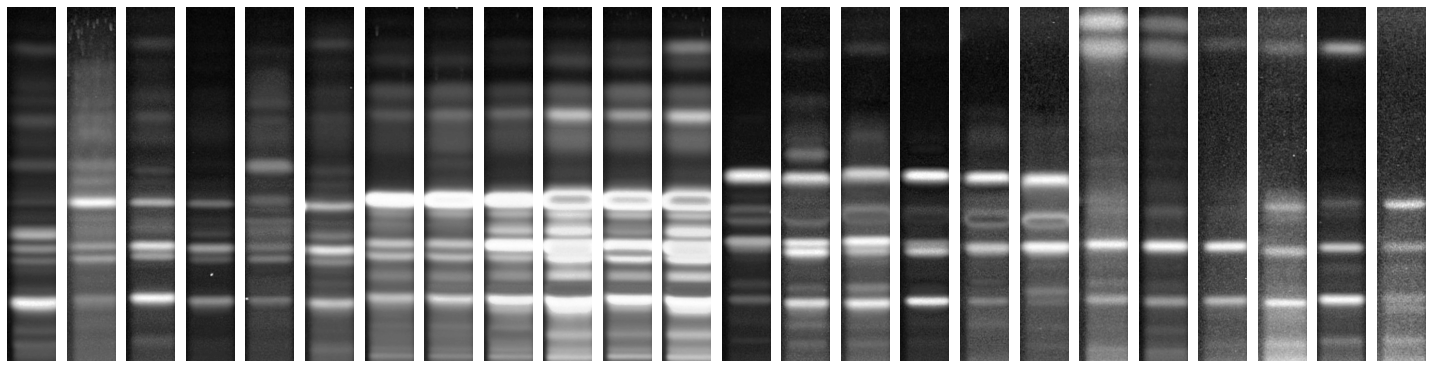

In [12]:
# Individual Print
# strip_array = strip_array_list[1]
strip_array = multiview_strip_array[1]
fig = plt.figure(figsize=(20, 10))
for i, strip in enumerate(strip_array):
    sub = fig.add_subplot(1, 24, i + 1)
    sub.axis('off')
    sub.imshow(strip,cmap='gray')
plt.tight_layout()

### Transforming each Strip in array to a 1D Vector by getting average value of each row

In [13]:
multiview_strip_row_avg_list = []

for strip_array in multiview_strip_array:
    strip_row_avg = []

    for i, strip in enumerate(strip_array):
        strip_row_avg.append([])
        for row in strip:
            strip_row_avg[i].append(row.mean())

    multiview_strip_row_avg_list.append(strip_row_avg)

In [14]:
np.shape(multiview_strip_row_avg_list[0][0])

(1030,)

In [15]:
np.shape(np.transpose([multiview_strip_row_avg_list[0][i] for k in range(min_width)]))

(1030, 140)

#### Plotting arrays of average values to verify mean of each row

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

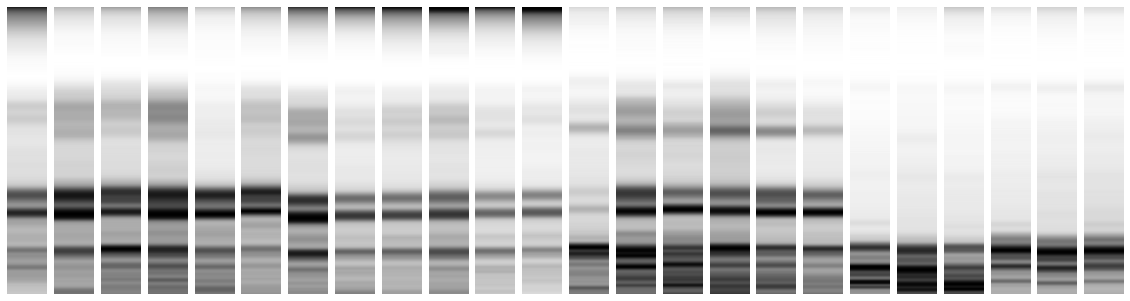

In [16]:
# Individual
fig = plt.figure(figsize=(20, 10)) 
for i in range(24):
    sub = fig.add_subplot(1, 24, i + 1)
    sub.axis('off')
    img = [multiview_strip_row_avg_list[-1][i] for k in range(min_width)]
    img = np.transpose(img)
    sub.imshow(img, cmap='gray')
plt.tight_layout

### Setting up Target Values & Dictionary Mapping

In [17]:
# 1 (GG): Rows 1 - 6 
# 2 (GI): Rows 7 - 12
# 3 (GU): Rows 13 - 18
# 4 (GE): Rows 19 - 21
# 5 (GL): Rows 22 - 24
map = {1:'GG',2:'GI',3:'GU',4:'GE',5:'GL'}
print(map[4])

GE


In [18]:
np.shape(multiview_strip_row_avg_list)

(8, 24, 1030)

In [19]:
np.shape(multiview_strip_row_avg_list[0])

(24, 1030)

In [20]:
#Done for the purposes of appending all views into 1 long feature vector later
no_targets_multiview_strip_row_avg_list = np.array(multiview_strip_row_avg_list).copy()

##### Append Targets to feature array

In [21]:
for strip_row_avg in multiview_strip_row_avg_list:
    for i in range(6):
        # strip_row_avg[i].append(1)
        strip_row_avg[i] = np.append(strip_row_avg[i],1)
    for i in range(6,12):
        # strip_row_avg[i].append(2)
        strip_row_avg[i] = np.append(strip_row_avg[i],2)
    for i in range(12,18):
        # strip_row_avg[i].append(3)
        strip_row_avg[i] = np.append(strip_row_avg[i],3)
    for i in range(18,21):
        # strip_row_avg[i].append(4)
        strip_row_avg[i] = np.append(strip_row_avg[i],4)
    for i in range(21,24):
        # strip_row_avg[i].append(5)
        strip_row_avg[i] = np.append(strip_row_avg[i],5)

In [22]:
#Verifying Shape of Multiview Multi-Dimensional Array
print(np.shape(multiview_strip_row_avg_list))

(8, 24, 1031)


In [23]:
# Verifying values are w/n the 0 - 1 range
print(np.shape(multiview_strip_row_avg_list[0][0]))
print(max(multiview_strip_row_avg_list[0][0]))
print(min(multiview_strip_row_avg_list[0][0]))

(1031,)
1.0
0.046075564761115705


### Get the Encoding for every Sample on every Tree in every View

#### Save mapping of resulting Trees to Number of Leaves in aformentioned Tree for each original feature vector (strip)

In [24]:
multiViewInputLeafEncoding = []
multiViewTreeLeafCountMap = {} #NEW
#Train the model per view
for i, strip_row_avg in enumerate(multiview_strip_row_avg_list):

    #Convert to Dataframe
    strip_row_avg = pd.DataFrame(strip_row_avg)

    #Get Features
    df_feat = strip_row_avg.iloc[:,:-2]

    #Get Targets & Format to 1D vector
    df_target = strip_row_avg.iloc[:,-1:]
    df_target = df_target.values.ravel()

    #Create Model
    model = RandomForestClassifier()

    #Set Model Parameters
    model.set_params(n_estimators=20,
                    max_depth=4,
                    random_state=101)

    #Train Model
    model.fit(df_feat,df_target)

    #Get Every Tree in forest
    everyTree = [estimator for estimator in model.estimators_]

    #####Get leaf indicies of sample applied to each tree in forest
    leafResultIndxs = model.apply(df_feat)

    #####Gets the indexes of the leaves for every tree
    ##### AND mapping for number of leaves per tree
    indxOfLeavesEveryTree = []
    singleViewTreeLeafCountMap = {}
    for k, tree in enumerate(everyTree):
        #Array where each node has the number of its left children BUT leaves have -1
        allChildren = tree.tree_.children_left
        #Get all leaves
        indxOfLeaves = np.where(allChildren == -1)[0]
        indxOfLeavesEveryTree.append(list(indxOfLeaves))

        #AddMapping
        singleViewTreeLeafCountMap[tree] = tree.tree_.n_leaves
        
    #####Get the encoding for each tree in a single view
    singleViewInputLeafEncoding = []
    #For every strip's row of resulting leaf indexes,
    for stripLeafResultIndxs in leafResultIndxs:
        #Create an array to save each tree's encoding to
        singleStripLeafEncoding = []
        #For every resulting leaf index in that row
        for treeNum, treeLeafResultIndex in enumerate(stripLeafResultIndxs):
            #Create the encoding for that tree
            treeLeafEncoding = [int(x == treeLeafResultIndex) for x in indxOfLeavesEveryTree[treeNum]]
            singleStripLeafEncoding.append(treeLeafEncoding.copy())
        #Append the encoding for that tree after flattening
        singleViewInputLeafEncoding.append(np.concatenate(singleStripLeafEncoding.copy()).ravel())

    #Append the encoding created for a view to a list of all the views
    multiViewInputLeafEncoding.append(singleViewInputLeafEncoding)
    multiViewTreeLeafCountMap[i] = singleViewTreeLeafCountMap

In [25]:
print(np.shape(multiViewInputLeafEncoding))

(8, 24)


c:\Python39\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


#### Save Encodings to CSV

In [26]:
for i, oneViewInputLeafEncoding in enumerate(multiViewInputLeafEncoding):
    tempStr = 'treeLeafEncodingData/leafEncodingView'+str(i+1)+'.csv'
    np.savetxt(tempStr, np.asarray(oneViewInputLeafEncoding), delimiter=',')

#### Reminder about how to iterate through Dictionary
Dictionary Format:

    * key = tree object
    * value = n_leaves

In [27]:
for key in multiViewTreeLeafCountMap[0]:
    print(key)
    print(multiViewTreeLeafCountMap[0][key])

DecisionTreeClassifier(max_depth=4, max_features='auto', random_state=70431583)
5
DecisionTreeClassifier(max_depth=4, max_features='auto', random_state=225658379)
7
DecisionTreeClassifier(max_depth=4, max_features='auto', random_state=303514961)
6
DecisionTreeClassifier(max_depth=4, max_features='auto',
                       random_state=1944264518)
5
DecisionTreeClassifier(max_depth=4, max_features='auto', random_state=122295871)
5
DecisionTreeClassifier(max_depth=4, max_features='auto',
                       random_state=2080686679)
4
DecisionTreeClassifier(max_depth=4, max_features='auto', random_state=736679933)
6
DecisionTreeClassifier(max_depth=4, max_features='auto', random_state=5713995)
5
DecisionTreeClassifier(max_depth=4, max_features='auto', random_state=795758575)
6
DecisionTreeClassifier(max_depth=4, max_features='auto', random_state=146505097)
5
DecisionTreeClassifier(max_depth=4, max_features='auto',
                       random_state=1434076109)
7
DecisionTreeClassi

# Feed Leaf Encoding into LinearSVC

### Import Encoding Data

In [28]:
allViewsEnc = []
list_files = os.listdir(dataTreeLeafEncoding)
list_files = natsorted(list_files)
for filename in list_files:
    allViewsEnc.append(np.loadtxt(dataTreeLeafEncoding+filename, delimiter=','))

In [29]:
for i in range(len(allViewsEnc)):
    print(np.shape(allViewsEnc[i]))

(24, 114)
(24, 109)
(24, 113)
(24, 123)
(24, 120)
(24, 100)
(24, 99)
(24, 103)


In [30]:
display(pd.DataFrame(allViewsEnc[0]))

0    1    2    3    4    5    6    7    8    9    ...  104  105  106  107  \
0   1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...  1.0  0.0  0.0  0.0   
1   1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  ...  0.0  0.0  0.0  1.0   
2   0.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
3   0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  1.0  0.0  0.0  0.0   
4   0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  1.0  0.0  0.0  0.0   
5   1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
6   0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  1.0  0.0   
7   0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  1.0  0.0   
8   0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  1.0  0.0   
9   0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  1.0  0.0   
10  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  1.0  0.0   
11  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  1.0  0.0   
12  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
13  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  1.0  0.0  0.0   
14  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  ...  0.0  0.0  0.0  0.0   
15  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  1.0  0.0  0.0  0.0   
16  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  ...  0.0  0.0  0.0  0.0   
17  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
18  1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
19  1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
20  1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
21  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  1.0   
22  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  1.0  0.0  0.0   
23  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  ...  1.0  0.0  0.0  0.0   

    108  109  110  111  112  113  
0   0.0  1.0  0.0  0.0  0.0  0.0  
1   0.0  0.0  0.0  0.0  0.0  0.0  
2   0.0  1.0  0.0  0.0  0.0  0.0  
3   0.0  0.0  0.0  0.0  1.0  0.0  
4   0.0  0.0  0.0  1.0  0.0  0.0  
5   0.0  1.0  0.0  0.0  0.0  0.0  
6   0.0  0.0  0.0  0.0  0.0  1.0  
7   0.0  0.0  0.0  0.0  0.0  1.0  
8   0.0  0.0  0.0  0.0  0.0  1.0  
9   0.0  0.0  0.0  0.0  0.0  1.0  
10  0.0  0.0  0.0  0.0  0.0  1.0  
11  0.0  0.0  0.0  0.0  0.0  1.0  
12  0.0  0.0  0.0  1.0  0.0  0.0  
13  0.0  0.0  0.0  1.0  0.0  0.0  
14  0.0  1.0  0.0  0.0  0.0  0.0  
15  0.0  0.0  0.0  1.0  0.0  0.0  
16  0.0  0.0  0.0  1.0  0.0  0.0  
17  0.0  0.0  0.0  1.0  0.0  0.0  
18  1.0  0.0  0.0  0.0  0.0  0.0  
19  1.0  0.0  0.0  0.0  0.0  0.0  
20  1.0  0.0  0.0  0.0  0.0  0.0  
21  0.0  0.0  0.0  0.0  0.0  0.0  
22  0.0  0.0  0.0  0.0  1.0  0.0  
23  0.0  0.0  1.0  0.0  0.0  0.0  

[24 rows x 114 columns]

In [31]:
display(np.transpose(pd.DataFrame(np.append(allViewsEnc[0][0],1))))

0    1    2    3    4    5    6    7    8    9    ...  105  106  107  108  \
0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   

   109  110  111  112  113  114  
0  1.0  0.0  0.0  0.0  0.0  1.0  

[1 rows x 115 columns]

### Setting up Target Values & Dictionary Mapping

In [32]:
# 1 (GG): Rows 1 - 6 
# 2 (GI): Rows 7 - 12
# 3 (GU): Rows 13 - 18
# 4 (GE): Rows 19 - 21
# 5 (GL): Rows 22 - 24
map = {1:'GG',2:'GI',3:'GU',4:'GE',5:'GL'}
print(map[4])

GE


In [33]:
allViewsEncTargets = []
for viewEnc in allViewsEnc:
    newViewEncTarget = []
    for i in range(6):
        newViewEncTarget.append(np.append(viewEnc[i],1))
    for i in range(6,12):
        newViewEncTarget.append(np.append(viewEnc[i],2))
    for i in range(12,18):
        newViewEncTarget.append(np.append(viewEnc[i],3))
    for i in range(18,21):
        newViewEncTarget.append(np.append(viewEnc[i],4))
    for i in range(21,24):
        newViewEncTarget.append(np.append(viewEnc[i],5))

    newViewEncTarget = pd.DataFrame(newViewEncTarget)
    # display(newViewEncTarget)

    allViewsEncTargets.append(newViewEncTarget)

display(pd.DataFrame(allViewsEncTargets[1]))

0    1    2    3    4    5    6    7    8    9    ...  100  101  102  103  \
0   1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...  0.0  1.0  0.0  0.0   
1   0.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
2   0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  ...  0.0  1.0  0.0  0.0   
3   0.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  ...  0.0  1.0  0.0  0.0   
4   0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  ...  0.0  1.0  0.0  0.0   
5   0.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  ...  0.0  1.0  0.0  0.0   
6   0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  ...  0.0  0.0  0.0  1.0   
7   0.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0  ...  0.0  0.0  0.0  1.0   
8   0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  ...  0.0  0.0  0.0  1.0   
9   0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  ...  0.0  0.0  0.0  1.0   
10  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  ...  0.0  0.0  0.0  1.0   
11  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  ...  0.0  0.0  0.0  1.0   
12  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  ...  0.0  0.0  1.0  0.0   
13  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  ...  0.0  0.0  1.0  0.0   
14  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  ...  0.0  0.0  1.0  0.0   
15  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  ...  0.0  0.0  0.0  1.0   
16  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  ...  0.0  0.0  1.0  0.0   
17  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  ...  0.0  0.0  1.0  0.0   
18  1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
19  1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
20  1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
21  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
22  0.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  ...  1.0  0.0  0.0  0.0   
23  0.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  ...  1.0  0.0  0.0  0.0   

    104  105  106  107  108  109  
0   0.0  0.0  0.0  1.0  0.0  1.0  
1   1.0  0.0  0.0  0.0  0.0  1.0  
2   0.0  0.0  0.0  1.0  0.0  1.0  
3   0.0  0.0  0.0  1.0  0.0  1.0  
4   0.0  0.0  0.0  1.0  0.0  1.0  
5   0.0  0.0  1.0  0.0  0.0  1.0  
6   0.0  1.0  0.0  0.0  0.0  2.0  
7   0.0  1.0  0.0  0.0  0.0  2.0  
8   0.0  1.0  0.0  0.0  0.0  2.0  
9   0.0  1.0  0.0  0.0  0.0  2.0  
10  0.0  1.0  0.0  0.0  0.0  2.0  
11  0.0  1.0  0.0  0.0  0.0  2.0  
12  0.0  0.0  0.0  0.0  1.0  3.0  
13  0.0  0.0  0.0  0.0  1.0  3.0  
14  0.0  0.0  1.0  0.0  0.0  3.0  
15  0.0  0.0  0.0  0.0  1.0  3.0  
16  0.0  0.0  0.0  0.0  1.0  3.0  
17  1.0  0.0  0.0  0.0  0.0  3.0  
18  1.0  0.0  0.0  0.0  0.0  4.0  
19  1.0  0.0  0.0  0.0  0.0  4.0  
20  1.0  0.0  0.0  0.0  0.0  4.0  
21  0.0  0.0  1.0  0.0  0.0  5.0  
22  0.0  0.0  1.0  0.0  0.0  5.0  
23  0.0  0.0  1.0  0.0  0.0  5.0  

[24 rows x 110 columns]

### IGNORE: Train model on all Views using Various Regularizers

In [34]:
all_accuracies = []
all_nonzero_weight_cnts = []
regularizers =[.1,.15,.2,.25,.3,.35,.4,.45,.5]

for i, strip_encoding in enumerate(allViewsEncTargets):

    accuracy = []
    nonzero_weight_cnt = []

    #Convert to Dataframe
    strip_encoding = pd.DataFrame(strip_encoding)

    #Get Features
    df_feat = strip_encoding.iloc[:,:-2]

    #Get Targets & Format to 1D vector
    df_target = strip_encoding.iloc[:,-1:]
    df_target = df_target.values.ravel()

    #Create Model
    model = LinearSVC()

    #Set Model Parameters
    for r_c in regularizers:
        #l1, squared_hinge, dual = False
        model.set_params(random_state=101,
                        verbose=0,
                        max_iter=4500,
                        penalty='l1',
                        loss='squared_hinge',
                        dual=False,
                        C=r_c)

        #Print Model Params
        # print("Model Params: "+str(model.get_params()))

        #Train Model
        model.fit(df_feat,df_target)

        #Print Score
        # print("\nStrip "+str(i)+": "+str(model.score(df_feat,df_target).round(3)))
        accuracy.append(round(model.score(df_feat,df_target),3))

        #Append Count of Number of Non-Zero Weights
        nonzero_weight_cnt.append(np.count_nonzero(model.coef_))
        # print(np.count_nonzero(model.coef_))

    all_accuracies.append(accuracy)
    all_nonzero_weight_cnts.append(nonzero_weight_cnt)

    print('Strip '+str(i+1))
    results = pd.DataFrame({"Accuracy":accuracy,"Regularizers":regularizers,"Non-Zero Weight Count":nonzero_weight_cnt})
    display(results)

Strip 1


Accuracy  Regularizers  Non-Zero Weight Count
0     0.708          0.10                     18
1     0.875          0.15                     30
2     1.000          0.20                     34
3     1.000          0.25                     34
4     1.000          0.30                     39
5     1.000          0.35                     44
6     1.000          0.40                     44
7     1.000          0.45                     50
8     1.000          0.50                     45

Strip 2


Accuracy  Regularizers  Non-Zero Weight Count
0      0.75          0.10                     19
1      1.00          0.15                     24
2      1.00          0.20                     20
3      1.00          0.25                     21
4      1.00          0.30                     24
5      1.00          0.35                     24
6      1.00          0.40                     24
7      1.00          0.45                     24
8      1.00          0.50                     22

Strip 3


Accuracy  Regularizers  Non-Zero Weight Count
0      0.75          0.10                     12
1      1.00          0.15                     20
2      1.00          0.20                     22
3      1.00          0.25                     19
4      1.00          0.30                     23
5      1.00          0.35                     24
6      1.00          0.40                     25
7      1.00          0.45                     25
8      1.00          0.50                     24

Strip 4


Accuracy  Regularizers  Non-Zero Weight Count
0     0.750          0.10                      9
1     0.833          0.15                     21
2     0.958          0.20                     26
3     0.958          0.25                     28
4     0.958          0.30                     33
5     0.958          0.35                     36
6     0.958          0.40                     40
7     0.958          0.45                     45
8     1.000          0.50                     45

Strip 5


Accuracy  Regularizers  Non-Zero Weight Count
0     0.708          0.10                     13
1     1.000          0.15                     19
2     1.000          0.20                     24
3     1.000          0.25                     28
4     1.000          0.30                     33
5     1.000          0.35                     34
6     1.000          0.40                     32
7     1.000          0.45                     33
8     1.000          0.50                     34

Strip 6


Accuracy  Regularizers  Non-Zero Weight Count
0      0.75          0.10                     12
1      1.00          0.15                     22
2      1.00          0.20                     22
3      1.00          0.25                     24
4      1.00          0.30                     24
5      1.00          0.35                     25
6      1.00          0.40                     24
7      1.00          0.45                     25
8      1.00          0.50                     23

Strip 7


Accuracy  Regularizers  Non-Zero Weight Count
0      0.75          0.10                     15
1      1.00          0.15                     23
2      1.00          0.20                     23
3      1.00          0.25                     21
4      1.00          0.30                     22
5      1.00          0.35                     22
6      1.00          0.40                     25
7      1.00          0.45                     23
8      1.00          0.50                     24

Strip 8


Accuracy  Regularizers  Non-Zero Weight Count
0      0.75          0.10                     12
1      1.00          0.15                     21
2      1.00          0.20                     20
3      1.00          0.25                     22
4      1.00          0.30                     22
5      1.00          0.35                     21
6      1.00          0.40                     21
7      1.00          0.45                     20
8      1.00          0.50                     19

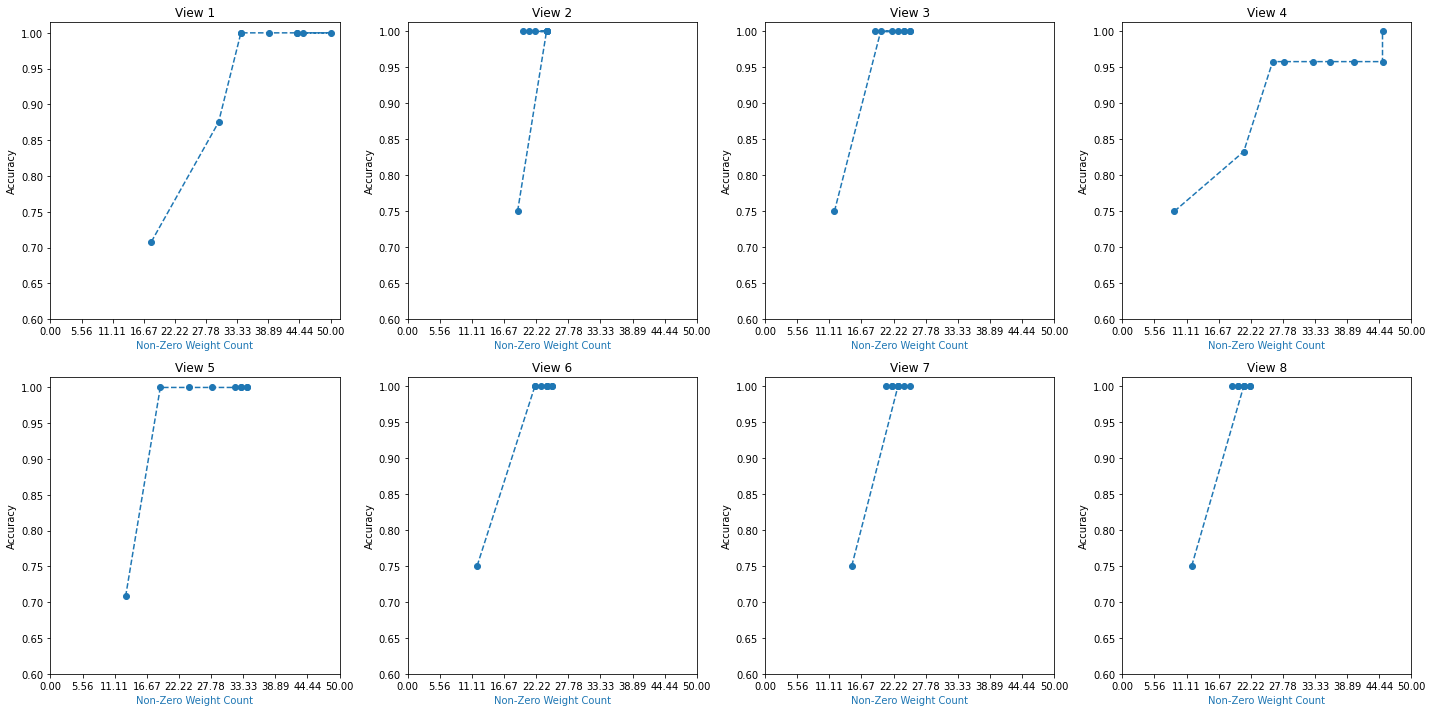

In [35]:
fig=plt.figure(figsize=(20, 10))

for j in range(8):
    #Non-Zero Weight Count Plot
    ax=fig.add_subplot(2, 4, j+1, label="1")

    ax.plot(all_nonzero_weight_cnts[j], all_accuracies[j], marker='o', color="C0", linestyle='dashed')

    ax.set_xlabel("Non-Zero Weight Count", color="C0")
    ax.set_ylabel("Accuracy", color="Black")
    ax.tick_params(axis='x', colors="Black")
    ax.tick_params(axis='y', colors="Black")
    ax.set_yticks([x * 0.05 for x in range(12, 21)])
    ax.set_xticks(np.linspace(0,50,10))

    ax.set_title("View "+str(j+1))

fig.tight_layout()

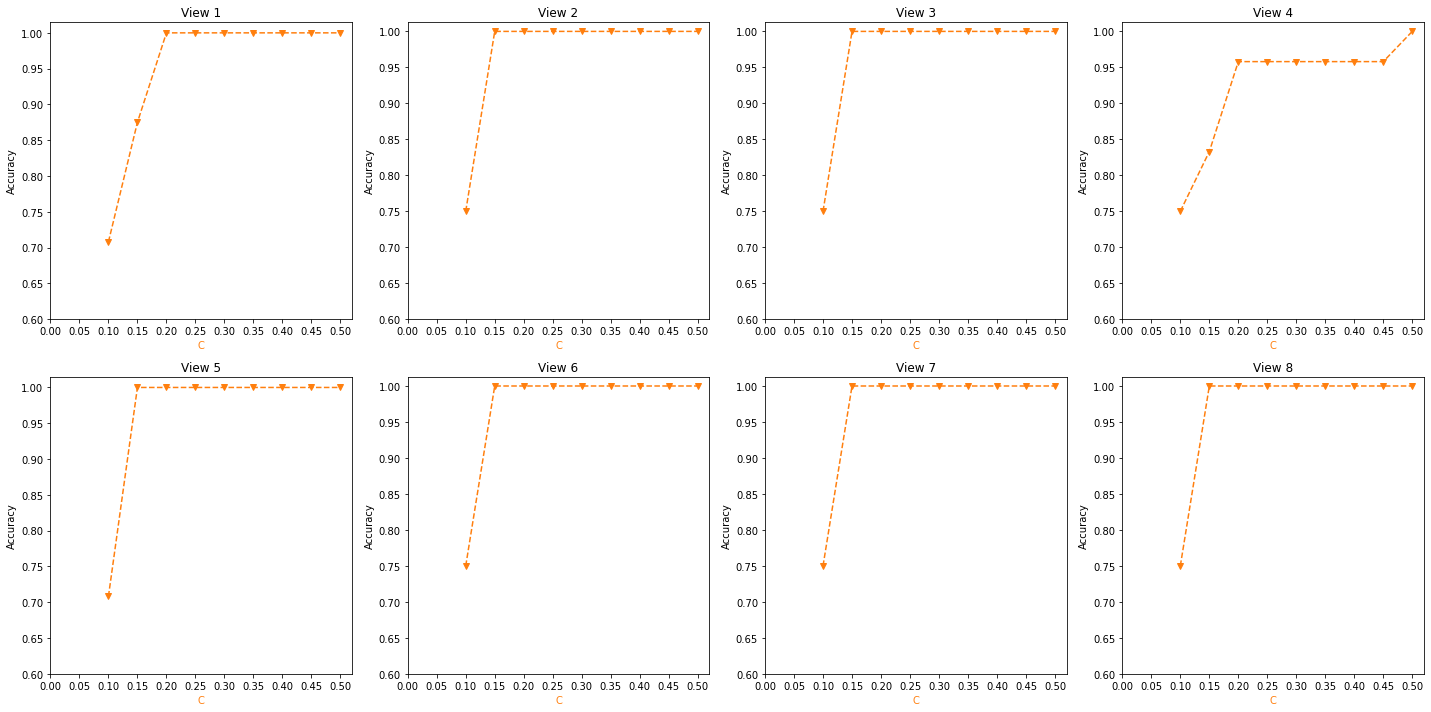

In [36]:
fig=plt.figure(figsize=(20, 10))

for j in range(8):
    #C Value Line
    ax2=fig.add_subplot(2, 4, j+1, label="2")

    ax2.plot(regularizers, all_accuracies[j], marker='v', color="C1", linestyle='dashed')

    # ax2.xaxis.tick_top()
    ax2.set_xlabel('C', color="C1") 
    ax2.set_ylabel("Accuracy", color="Black")
    ax2.tick_params(axis='x', colors="Black")
    ax2.set_yticks([x * 0.05 for x in range(12, 21)])
    ax2.set_xticks(np.linspace(0,.5,11))
    # ax2.xaxis.set_label_position('top')

    ax2.set_title("View "+str(j+1))

fig.tight_layout()

### Train model on all Views using Various Regularizers AND Get each view's Best Parameters (r)

In [37]:
all_accuracies = []
all_nonzero_weight_cnts = []
regularizers =[.1,.15,.2,.25,.3,.35,.4,.45,.5]
best_params = []

for i, strip_encoding in enumerate(allViewsEncTargets):

    accuracy = []
    nonzero_weight_cnt = []

    #Convert to Dataframe
    strip_encoding = pd.DataFrame(strip_encoding)

    #Get Features
    df_feat = strip_encoding.iloc[:,:-2]

    #Get Targets & Format to 1D vector
    df_target = strip_encoding.iloc[:,-1:]
    df_target = df_target.values.ravel()

    #Create Model
    model = LinearSVC()

    #Set Model Parameters
    for r_c in regularizers:
        #l1, squared_hinge, dual = False
        model.set_params(random_state=101,
                        verbose=0,
                        max_iter=4500,
                        penalty='l1',
                        loss='squared_hinge',
                        dual=False,
                        C=r_c)

        #Print Model Params
        # print("Model Params: "+str(model.get_params()))

        #Train Model
        model.fit(df_feat,df_target)

        #Print Score
        # print("\nStrip "+str(i)+": "+str(model.score(df_feat,df_target).round(3)))
        accuracy.append(round(model.score(df_feat,df_target),3))

        #Append Count of Number of Non-Zero Weights
        nonzero_weight_cnt.append(len(np.unique(pd.DataFrame(np.nonzero(model.coef_)).iloc[1])))
        # print(np.count_nonzero(model.coef_))

    all_accuracies.append(accuracy)
    all_nonzero_weight_cnts.append(nonzero_weight_cnt)

    print('View '+str(i+1))
    results = pd.DataFrame({"Accuracy":accuracy,"Regularizers":regularizers,"Non-Zero Weight Count":nonzero_weight_cnt})
    # display(results)

    #Get index of first 100% Accuracy row
    first_perfect_row_index = results[results.Accuracy==1.0].first_valid_index()

    #Get row at first_perfect_row_index
    first_perfect_row = pd.DataFrame(results.iloc[first_perfect_row_index])

    #Transpose to row format
    # first_perfect_row = first_perfect_row.transpose()

    #Change index name to match view number
    first_perfect_row = first_perfect_row.rename(columns={first_perfect_row_index:i})

    #Display and Append
    display(first_perfect_row)
    best_params.append(first_perfect_row)


View 1


0
Accuracy                1.0
Regularizers            0.2
Non-Zero Weight Count  33.0

View 2


1
Accuracy                1.00
Regularizers            0.15
Non-Zero Weight Count  24.00

View 3


2
Accuracy                1.00
Regularizers            0.15
Non-Zero Weight Count  20.00

View 4


3
Accuracy                1.0
Regularizers            0.5
Non-Zero Weight Count  38.0

View 5


4
Accuracy                1.00
Regularizers            0.15
Non-Zero Weight Count  17.00

View 6


5
Accuracy                1.00
Regularizers            0.15
Non-Zero Weight Count  22.00

View 7


6
Accuracy                1.00
Regularizers            0.15
Non-Zero Weight Count  23.00

View 8


7
Accuracy                1.00
Regularizers            0.15
Non-Zero Weight Count  21.00

In [38]:
np_best_params = np.array(best_params)
best_regularizer_per_view = []
for i in range(len(np_best_params)):
    print("View "+str(i+1)+" Regularizer: "+str(np_best_params[i][1]))
    best_regularizer_per_view.append(np_best_params[i][1])

View 1 Regularizer: [0.2]
View 2 Regularizer: [0.15]
View 3 Regularizer: [0.15]
View 4 Regularizer: [0.5]
View 5 Regularizer: [0.15]
View 6 Regularizer: [0.15]
View 7 Regularizer: [0.15]
View 8 Regularizer: [0.15]


In [39]:
print(best_regularizer_per_view)

[array([0.2]), array([0.15]), array([0.15]), array([0.5]), array([0.15]), array([0.15]), array([0.15]), array([0.15])]


### Train Model on e/ View w/ the best Regularizer to Get Unique Non-Zero Columns per View

In [40]:
all_accuracies = []
all_nonzero_weight_cnts = []
important_features_by_view = []

for i, strip_encoding in enumerate(allViewsEncTargets):

    accuracy = []
    nonzero_weight_cnt = []

    #Convert to Dataframe
    strip_encoding = pd.DataFrame(strip_encoding)

    #Get Features
    df_feat = strip_encoding.iloc[:,:-2]

    #Get Targets & Format to 1D vector
    df_target = strip_encoding.iloc[:,-1:]
    df_target = df_target.values.ravel()

    #Create Model
    model = LinearSVC()

    #Set Model Parameters
    for r_c in regularizers:
        #l1, squared_hinge, dual = False
        model.set_params(random_state=101,
                        verbose=0,
                        max_iter=4500,
                        penalty='l1',
                        loss='squared_hinge',
                        dual=False,
                        C=best_regularizer_per_view[i])

        #Train Model
        model.fit(df_feat,df_target)

        #Print Score
        accuracy.append(round(model.score(df_feat,df_target),3))

        #Append Count of Number of Non-Zero Weights
        nonzero_weight_cnt.append(len(np.unique(pd.DataFrame(np.nonzero(model.coef_)).iloc[1])))

    all_accuracies.append(accuracy)
    all_nonzero_weight_cnts.append(nonzero_weight_cnt)

    # print('Strip '+str(i+1))
    results = pd.DataFrame({"Accuracy":accuracy,"Regularizers":regularizers,"Non-Zero Weight Count":nonzero_weight_cnt})
    
    #####
    #Get Table of non-zero coefs in model's coef
    #   Row 1 holds the row index values in the full coef table
    #   Row 2 holds the column index values in the full coef table
    model_coefs_nonzero = pd.DataFrame(np.nonzero(model.coef_.copy()))

    #Get Array of Unique Columns with at least 1 non-zero value
    nonzero_cols = np.unique(model_coefs_nonzero.iloc[1])

    important_features_by_view.append(nonzero_cols)


In [41]:
#Number of Features at first occurence of 100% accuracy
for i in range(len(important_features_by_view)):
    print('View '+str(i+1)+': '+str(len(important_features_by_view[i])))
    print(str(important_features_by_view[i]))

View 1: 33
[  1   4  11  14  20  22  27  29  34  35  39  42  45  48  49  50  51  52
  55  60  63  64  66  68  70  71  78  83  87  94 106 108 111]
View 2: 24
[  9  13  16  19  21  25  27  40  41  42  46  47  57  59  64  65  66  67
  75  80  86  90  97 105]
View 3: 20
[  3   7   8  10  27  30  47  48  62  71  72  84  87  93  95  99 101 106
 108 111]
View 4: 38
[  2   4   8   9  10  19  27  28  31  36  37  39  43  44  49  50  52  53
  56  63  67  69  75  80  82  85  88  92  93  95  98 101 103 104 109 111
 114 119]
View 5: 17
[  2  16  26  31  35  36  42  50  62  68  71  78  92 105 108 111 118]
View 6: 22
[ 0 15 18 20 21 38 44 46 47 51 52 56 57 58 64 65 79 83 87 88 91 98]
View 7: 23
[ 7 12 13 14 15 25 34 35 36 49 51 57 58 59 61 64 74 75 76 77 78 89 97]
View 8: 21
[  3   4   8  12  15  29  34  40  56  69  71  77  78  81  84  91  92  93
  94  95 101]


# Get Original Features used in Trees whose Leaves were Important

##### Important Objects

In [42]:
#Hash of tree:n_leaves
multiViewTreeLeafCountMap

#Array of Important Tree Leaves by view
important_features_by_view

[array([  1,   4,  11,  14,  20,  22,  27,  29,  34,  35,  39,  42,  45,
         48,  49,  50,  51,  52,  55,  60,  63,  64,  66,  68,  70,  71,
         78,  83,  87,  94, 106, 108, 111], dtype=int64),
 array([  9,  13,  16,  19,  21,  25,  27,  40,  41,  42,  46,  47,  57,
         59,  64,  65,  66,  67,  75,  80,  86,  90,  97, 105], dtype=int64),
 array([  3,   7,   8,  10,  27,  30,  47,  48,  62,  71,  72,  84,  87,
         93,  95,  99, 101, 106, 108, 111], dtype=int64),
 array([  2,   4,   8,   9,  10,  19,  27,  28,  31,  36,  37,  39,  43,
         44,  49,  50,  52,  53,  56,  63,  67,  69,  75,  80,  82,  85,
         88,  92,  93,  95,  98, 101, 103, 104, 109, 111, 114, 119],
       dtype=int64),
 array([  2,  16,  26,  31,  35,  36,  42,  50,  62,  68,  71,  78,  92,
        105, 108, 111, 118], dtype=int64),
 array([ 0, 15, 18, 20, 21, 38, 44, 46, 47, 51, 52, 56, 57, 58, 64, 65, 79,
        83, 87, 88, 91, 98], dtype=int64),
 array([ 7, 12, 13, 14, 15, 25, 34, 35, 36,

##### IGNORE: Get All unique trees from a single View's Important leaves

In [43]:
#Create simple array where i = feature index, value = tree

#FOR A SINGLE VIEW
singleViewTreeAtFeatureList = []

singleViewTreeLeafCountMap = multiViewTreeLeafCountMap[0]

for key in singleViewTreeLeafCountMap:
    for i in range(singleViewTreeLeafCountMap[key]):
        singleViewTreeAtFeatureList.append(key)

print(len(singleViewTreeAtFeatureList))
print(singleViewTreeAtFeatureList[0])
print(singleViewTreeAtFeatureList[0].tree_.n_leaves)

114
DecisionTreeClassifier(max_depth=4, max_features='auto', random_state=70431583)
5


In [44]:
#Create a list of all Unique Trees in a Single View's Important Leaves
SingleViewUniqueTrees = []

important_features_single_view = important_features_by_view[0]
print("Number of important features in this single view: "+str(len(important_features_single_view)))

for feature in important_features_single_view:
    if singleViewTreeAtFeatureList[feature] not in SingleViewUniqueTrees:
        SingleViewUniqueTrees.append(singleViewTreeAtFeatureList[feature])

print("Number of Unique Trees used in Important Features: "+str(len(SingleViewUniqueTrees)))
print(SingleViewUniqueTrees[0])
# for i in range(len(SingleViewUniqueTrees)):
#     print(SingleViewUniqueTrees[i])
#     print(SingleViewUniqueTrees[i].tree_.n_leaves)

Number of important features in this single view: 33
Number of Unique Trees used in Important Features: 18
DecisionTreeClassifier(max_depth=4, max_features='auto', random_state=70431583)


In [45]:
#Get Original Features from SingleViewUniqueTrees
SingleViewOriginalFeaturesInUniqueTrees = []

for i in range(len(SingleViewUniqueTrees)):
    # print(np.shape(SingleViewUniqueTrees[i].feature_importances_))
    # print(np.nonzero(SingleViewUniqueTrees[i].feature_importances_))
    # print(np.flatnonzero(SingleViewUniqueTrees[i].feature_importances_))

    SingleViewOriginalFeaturesInUniqueTrees.append(list(np.flatnonzero(SingleViewUniqueTrees[i].feature_importances_)))
    # break
SingleViewOriginalFeaturesInUniqueTrees = np.concatenate(np.array(SingleViewOriginalFeaturesInUniqueTrees,dtype=object)).ravel()
print(SingleViewOriginalFeaturesInUniqueTrees)
print(len(SingleViewOriginalFeaturesInUniqueTrees))
SingleViewOriginalFeaturesInUniqueTrees = np.unique(SingleViewOriginalFeaturesInUniqueTrees)
print(SingleViewOriginalFeaturesInUniqueTrees)
print(len(SingleViewOriginalFeaturesInUniqueTrees))

[105 236 370 497 226 284 347 401 505 669 384 609 665 730 860 276 497 580
 676   8 393 415 731 339 391 509 556 683 801 826 908 112 349 385 498 151
 695 730 848 874  10  75 392 492  68 236 486 661 813 279 351 520 634 761
 358 404 498 910 219 273 379 585 191 232 265 432 257 488 632 667 696 859
 280 346 876 920  21 265 655 787 801 854]
82
[  8  10  21  68  75 105 112 151 191 219 226 232 236 257 265 273 276 279
 280 284 339 346 347 349 351 358 370 379 384 385 391 392 393 401 404 415
 432 486 488 492 497 498 505 509 520 556 580 585 609 632 634 655 661 665
 667 669 676 683 695 696 730 731 761 787 801 813 826 848 854 859 860 874
 876 908 910 920]
76


In [46]:
# Function to Extract intervals from an array of values
# Expects list to be already sorted
# Strictness is how far apart values can be to be considered 'adjacent'
def interval_extract_loose(list, strictness):
    length = len(list)
    i = 0
    while (i< length):
        low = list[i]
        while i <length-1 and list[i]+strictness >= list[i + 1]: # the 2 can be variable
            i += 1
        high = list[i]
        if (high - low >= 1):
            yield [low, high]
        elif (high - low == 1):
            yield [low, ]
            yield [high, ]
        else:
            yield [low, ]
        i += 1

In [47]:
single_view_intervals = list(interval_extract_loose(SingleViewOriginalFeaturesInUniqueTrees,10))
print(len(single_view_intervals))
print(single_view_intervals)

29
[[8, 10], [21], [68, 75], [105, 112], [151], [191], [219, 236], [257, 284], [339, 358], [370, 404], [415], [432], [486, 509], [520], [556], [580, 585], [609], [632, 634], [655, 683], [695, 696], [730, 731], [761], [787], [801], [813], [826], [848, 860], [874, 876], [908, 920]]


### Get Unique Original Features based on Important Features in Encoded Trees in All Views

#### Determine Unique Trees of Important Leaves for All Views

In [48]:
#Create an array for to hold all the trees at their encoded index in each view
multiViewTreeAtFeatureList = []
for i in range(len(multiViewTreeLeafCountMap)):
    #Create simple array where i = feature index, value = tree
    #FOR A SINGLE VIEW
    singleViewTreeAtFeatureList = []

    singleViewTreeLeafCountMap = multiViewTreeLeafCountMap[i]

    for key in singleViewTreeLeafCountMap:
        for i in range(singleViewTreeLeafCountMap[key]):
            singleViewTreeAtFeatureList.append(key)
    #Save to array of all Views
    multiViewTreeAtFeatureList.append(singleViewTreeAtFeatureList)
print(len(multiViewTreeAtFeatureList))

8


In [49]:
#Create an array to hold all the unique trees in each view
multiViewUniqueTrees = []
for i in range(len(multiViewTreeAtFeatureList)):
    #Create a list of all Unique Trees in a Single View's Important Leaves
    SingleViewUniqueTrees = []

    important_features_single_view = important_features_by_view[i]
    print("Number of important features in this single view: "+str(len(important_features_single_view)))

    for feature in important_features_single_view:
        if multiViewTreeAtFeatureList[i][feature] not in SingleViewUniqueTrees:
            SingleViewUniqueTrees.append(multiViewTreeAtFeatureList[i][feature])

    print("Number of Unique Trees used in Important Features: "+str(len(SingleViewUniqueTrees))+"\n")
    # print(SingleViewUniqueTrees[0])
    multiViewUniqueTrees.append(SingleViewUniqueTrees)

print(len(multiViewUniqueTrees))
print(len(multiViewUniqueTrees[1]))

Number of important features in this single view: 33
Number of Unique Trees used in Important Features: 18

Number of important features in this single view: 24
Number of Unique Trees used in Important Features: 15

Number of important features in this single view: 20
Number of Unique Trees used in Important Features: 13

Number of important features in this single view: 38
Number of Unique Trees used in Important Features: 19

Number of important features in this single view: 17
Number of Unique Trees used in Important Features: 15

Number of important features in this single view: 22
Number of Unique Trees used in Important Features: 12

Number of important features in this single view: 23
Number of Unique Trees used in Important Features: 12

Number of important features in this single view: 21
Number of Unique Trees used in Important Features: 14

8
15


#### Determine Original Features using Unique Trees on All Views

In [50]:
MultiViewOriginalFeaturesInUniqueTrees = []
for SingleViewUniqueTrees in multiViewUniqueTrees:
    #Get Original Features from SingleViewUniqueTrees
    SingleViewOriginalFeaturesInUniqueTrees = []

    for i in range(len(SingleViewUniqueTrees)):

        SingleViewOriginalFeaturesInUniqueTrees.append(list(np.flatnonzero(SingleViewUniqueTrees[i].feature_importances_)))

    SingleViewOriginalFeaturesInUniqueTrees = np.concatenate(np.array(SingleViewOriginalFeaturesInUniqueTrees,dtype=object)).ravel()
    SingleViewOriginalFeaturesInUniqueTrees = np.unique(SingleViewOriginalFeaturesInUniqueTrees)

    MultiViewOriginalFeaturesInUniqueTrees.append(SingleViewOriginalFeaturesInUniqueTrees)

print(len(MultiViewOriginalFeaturesInUniqueTrees))
print(MultiViewOriginalFeaturesInUniqueTrees[1])

8
[   8   21   22   29   46   50   83  111  160  170  253  324  333  455
  478  485  486  492  498  503  504  505  506  510  533  534  547  562
  563  564  573  579  580  581  585  621  630  642  645  665  681  683
  696  705  713  717  718  729  730  731  733  734  737  765  859  878
  899  907  976  977  982 1008 1019 1020]


#### Determine number of uniqe features by view

In [51]:
for i in range(len(MultiViewOriginalFeaturesInUniqueTrees)):
    print("View "+str(i+1)+" features: "+str(len(MultiViewOriginalFeaturesInUniqueTrees[i])))
    

View 1 features: 76
View 2 features: 64
View 3 features: 55
View 4 features: 91
View 5 features: 65
View 6 features: 48
View 7 features: 45
View 8 features: 58


In [52]:
print(MultiViewOriginalFeaturesInUniqueTrees)

[array([  8,  10,  21,  68,  75, 105, 112, 151, 191, 219, 226, 232, 236,
       257, 265, 273, 276, 279, 280, 284, 339, 346, 347, 349, 351, 358,
       370, 379, 384, 385, 391, 392, 393, 401, 404, 415, 432, 486, 488,
       492, 497, 498, 505, 509, 520, 556, 580, 585, 609, 632, 634, 655,
       661, 665, 667, 669, 676, 683, 695, 696, 730, 731, 761, 787, 801,
       813, 826, 848, 854, 859, 860, 874, 876, 908, 910, 920], dtype=int64), array([   8,   21,   22,   29,   46,   50,   83,  111,  160,  170,  253,
        324,  333,  455,  478,  485,  486,  492,  498,  503,  504,  505,
        506,  510,  533,  534,  547,  562,  563,  564,  573,  579,  580,
        581,  585,  621,  630,  642,  645,  665,  681,  683,  696,  705,
        713,  717,  718,  729,  730,  731,  733,  734,  737,  765,  859,
        878,  899,  907,  976,  977,  982, 1008, 1019, 1020], dtype=int64), array([  27,   29,   46,   63,   64,   69,   73,   86,   93,  136,  140,
        153,  210,  219,  232,  241,  254,  271,

# Union of Intervals Overlapping across All Views

### Setup for Training on features at Center of Intervals in important features across all Views

#### Remove Warnings

In [53]:
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

#### Combine Important Features from Each View into one long List

In [54]:
# Combine all our View's 'Important Features' and Sort and get only unique
combined_important_features = np.concatenate(MultiViewOriginalFeaturesInUniqueTrees)
combined_important_features = np.sort(combined_important_features)
combined_important_features = np.unique(combined_important_features)
print(len(combined_important_features))
print(combined_important_features)

321
[   3    6    7    8    9   10   11   14   15   16   18   21   22   23
   25   26   27   29   30   33   34   35   36   46   48   50   51   52
   54   63   64   66   68   69   73   75   79   81   83   86   91   92
   93   95   96  103  105  111  112  128  130  136  139  140  151  153
  156  160  167  170  183  191  210  211  213  218  219  220  221  222
  225  226  232  236  241  249  253  254  257  265  271  273  276  277
  279  280  284  291  295  324  333  339  346  347  349  351  357  358
  365  367  369  370  379  384  385  391  392  393  398  399  400  401
  404  409  411  415  417  432  435  441  447  448  450  454  455  456
  458  460  463  469  470  476  478  479  482  483  485  486  488  491
  492  494  497  498  503  504  505  506  509  510  514  516  520  531
  533  534  535  536  537  544  547  550  554  555  556  562  563  564
  570  571  573  579  580  581  583  585  591  593  597  599  605  609
  621  628  630  632  634  635  642  643  644  645  649  651  652  654
  

#### Define Interval Extraction for center Feature

In [55]:
# Function to Extract intervals from an array of values
# Expects list to be already sorted
# Strictness is how far apart values can be to be considered 'adjacent'
def interval_extract_loose(list, strictness):
    length = len(list)
    i = 0
    while (i< length):
        low = list[i]
        while i <length-1 and list[i]+strictness >= list[i + 1]: # the 2 can be variable
            i += 1
        high = list[i]
        if (high - low >= 1):
            yield [low, high]
        elif (high - low == 1):
            yield [low, ]
            yield [high, ]
        else:
            yield [low, ]
        i += 1

#### Get ends of Intervals

In [56]:
#Get intervals for sorted list of combined important features
all_possible_intervals = list(interval_extract_loose(combined_important_features,10))

print(len(all_possible_intervals))
print(all_possible_intervals)

12
[[3, 112], [128, 140], [151, 170], [183, 191], [210, 295], [324, 417], [432, 520], [531, 609], [621, 718], [729, 835], [848, 959], [970, 1028]]


In [57]:
#Print length of each interval
lengths_of_intervals = []
for item in all_possible_intervals:
    if len(item) == 2:
        lengths_of_intervals.append(item[1]-item[0])
print(lengths_of_intervals)

[109, 12, 19, 8, 85, 93, 88, 78, 97, 106, 111, 58]


#### Get Center of Intervals

In [58]:
#Create array of
    # 1) All individual Values from 'all_possible_intervals' 
    # AND Center of any actual intervals from above array
    # 2) Only Center values from real intervals

centers_and_individual_intervals_of_all_intervals = []
only_centers_of_all_intervals = []

for item in all_possible_intervals:
    if len(item) == 2:
        center = int(round( (item[0]+item[1]) / 2, 0))
        only_centers_of_all_intervals.append(center)
        centers_and_individual_intervals_of_all_intervals.append(center)
    else:
        centers_and_individual_intervals_of_all_intervals.append(item[0])

# print(len(centers_and_individual_intervals_of_all_intervals))
print(len(only_centers_of_all_intervals))
print(only_centers_of_all_intervals)

12
[58, 134, 160, 187, 252, 370, 476, 570, 670, 782, 904, 999]


#### Append Target Column

In [59]:
# Append final column index to feature arrays which is 
# Target Column from original feature vector

#Get count of Original Features
original_number_of_features = len(multiview_strip_row_avg_list[0][0])

#Append count - 1 to end of new features
# centers_and_individual_intervals_of_all_intervals.append(original_number_of_features-1)
only_centers_of_all_intervals.append(original_number_of_features-1)

In [60]:
print(only_centers_of_all_intervals)

[58, 134, 160, 187, 252, 370, 476, 570, 670, 782, 904, 999, 1030]


In [61]:
# display(pd.DataFrame(multiview_strip_row_avg_list[0]))

#### Show Features used for Training

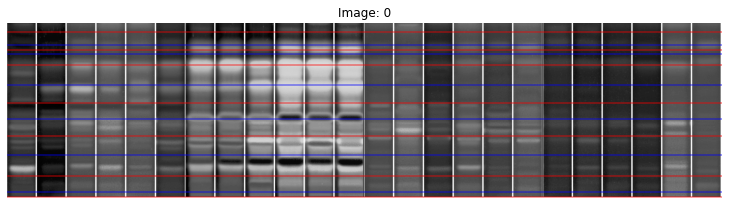

In [62]:
fig = plt.figure(figsize=(30, 15))
for i, img in enumerate(cropped_img_list):
    sub = fig.add_subplot(4, 2, i + 1)
    sub.axis('off')
    sub.imshow(img,cmap='gray')
    for m, val in enumerate(only_centers_of_all_intervals):
        if m % 2 == 0:
            c = 'red'
        else:
            c = 'blue'
        sub.axhline(val,color=c,alpha=.5)
    sub.set_title('Image: '+str(i))
    break
plt.tight_layout
fig.subplots_adjust(wspace=.02, hspace=.15)

#### Train Model

In [63]:
###Train only on features from `only_centers_of_all_intervals`, 
# across different regularizers AND
# on ALL VIEWS

minimized_best_params = []
all_accuracies = []
all_nonzero_weight_cnts = []
regularizers =[.7,.8,.9,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]

only_centers_results = []

for i, strip_row_avg in enumerate(multiview_strip_row_avg_list):

    accuracy = []
    nonzero_weight_cnt = []

    #Convert to Dataframe
    strip_row_avg = pd.DataFrame(strip_row_avg)

    #####
    
    #Get "Useful Features" from Current view using Center of Intervals
    strip_row_avg = strip_row_avg[only_centers_of_all_intervals]

    #####

    #Get Features
    df_feat = strip_row_avg.iloc[:,:-2]

    #Get Targets & Format to 1D vector
    df_target = strip_row_avg.iloc[:,-1:]
    df_target = df_target.values.ravel()

    #Create Model
    model = LinearSVC()

    #Set Model Parameters
    for r_c in regularizers:
        #l1, squared_hinge, dual = False
        model.set_params(random_state=101,
                        verbose=0,
                        max_iter=4500,
                        penalty='l1',
                        loss='squared_hinge',
                        dual=False,
                        tol=2e-3,
                        C=r_c)

        #Train Model
        model.fit(df_feat,df_target)

        #Print Score
        # print("\nStrip "+str(i)+": "+str(model.score(df_feat,df_target).round(3)))
        accuracy.append(round(model.score(df_feat,df_target),3))

        #Append Count of Number of Non-Zero Weights
        nonzero_weight_cnt.append(len(np.unique(pd.DataFrame(np.nonzero(model.coef_)).iloc[1])))
        # print(np.count_nonzero(model.coef_))

    all_accuracies.append(accuracy)
    all_nonzero_weight_cnts.append(nonzero_weight_cnt)

    print('View '+str(i+1))
    results = pd.DataFrame({"Accuracy":accuracy,"Regularizers":regularizers,"Unique Non-Zero Weight Count":nonzero_weight_cnt})
    # display(results)

    #Get index of first 100% Accuracy row
    first_perfect_row_index = results[results.Accuracy==1.0].first_valid_index()
    if first_perfect_row_index:

        #Get row at first_perfect_row_index
        first_perfect_row = pd.DataFrame(results.iloc[first_perfect_row_index])

        #Transpose to row format
        # first_perfect_row = first_perfect_row.transpose()

        #Change index name to match view number
        first_perfect_row = first_perfect_row.rename(columns={first_perfect_row_index:i})

        #Display and Append
        display(first_perfect_row)
        minimized_best_params.append(first_perfect_row)
        
    else:
        #Get index of Max Accuracy Row
        max_acc_row_index = results.idxmax()[0]

        #Get max Accuracy row at above index
        max_acc_row = pd.DataFrame(results.iloc[max_acc_row_index])

        #Change index name to match view number
        max_acc_row = max_acc_row.rename(columns={max_acc_row_index:i})

        #Display and Append
        display(max_acc_row)
        minimized_best_params.append(max_acc_row)

only_centers_results.append(minimized_best_params)

View 1


0
Accuracy                       1.0
Regularizers                  19.0
Unique Non-Zero Weight Count  11.0

View 2


1
Accuracy                      1.0
Regularizers                  8.0
Unique Non-Zero Weight Count  9.0

View 3


2
Accuracy                       0.875
Regularizers                  13.000
Unique Non-Zero Weight Count   9.000

View 4


3
Accuracy                       1.0
Regularizers                  11.0
Unique Non-Zero Weight Count   9.0

View 5


4
Accuracy                       0.917
Regularizers                  15.000
Unique Non-Zero Weight Count  10.000

View 6


5
Accuracy                       1.0
Regularizers                  14.0
Unique Non-Zero Weight Count  10.0

View 7


6
Accuracy                       1.0
Regularizers                   5.0
Unique Non-Zero Weight Count  11.0

View 8


7
Accuracy                       0.958
Regularizers                  16.000
Unique Non-Zero Weight Count  11.000

#### Graph Accuracy vs # of Features Used

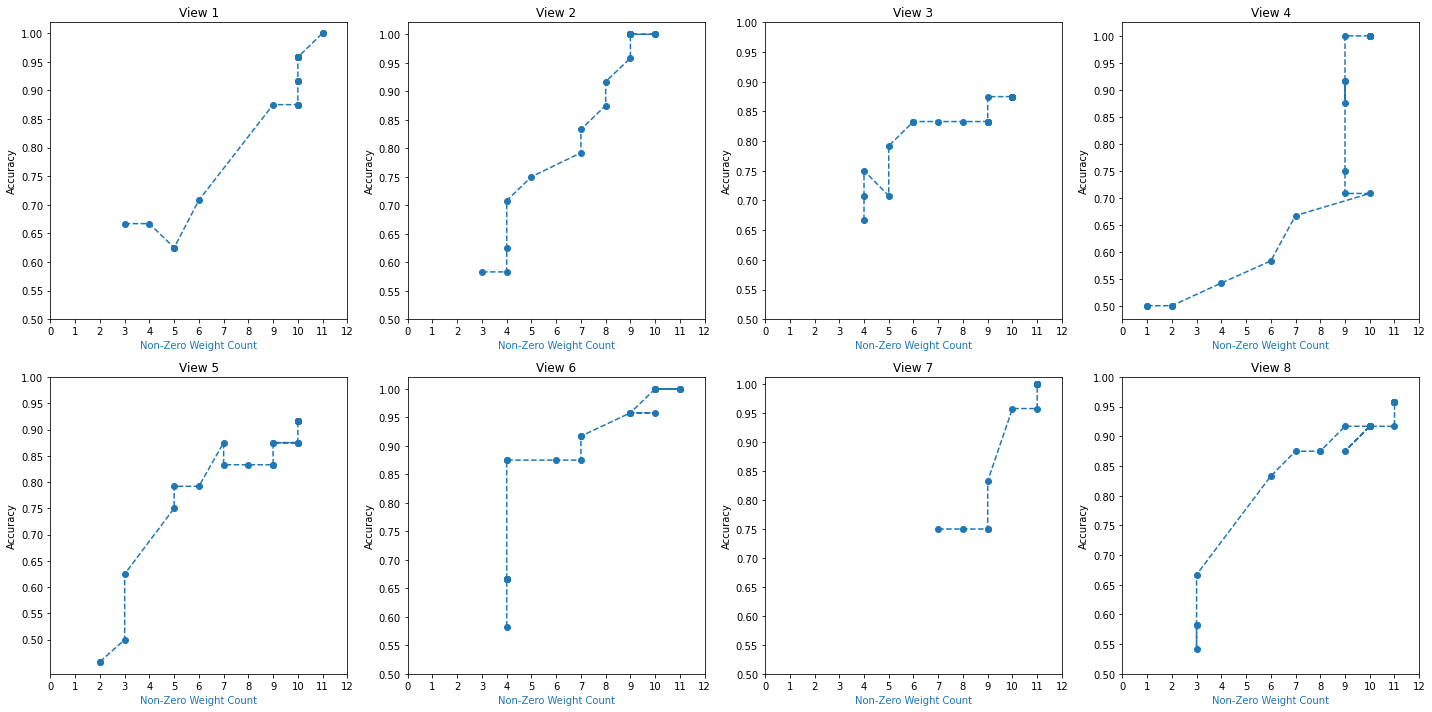

In [64]:
fig=plt.figure(figsize=(20, 10))

for j in range(8):
    #Non-Zero Weight Count Plot
    ax=fig.add_subplot(2, 4, j+1, label="1")

    ax.plot(all_nonzero_weight_cnts[j], all_accuracies[j], marker='o', color="C0", linestyle='dashed')

    ax.set_xlabel("Non-Zero Weight Count", color="C0")
    ax.set_ylabel("Accuracy", color="Black")
    ax.tick_params(axis='x', colors="Black")
    ax.tick_params(axis='y', colors="Black")
    ax.set_yticks([x * 0.05 for x in range(10, 21)])
    ax.set_xticks(np.linspace(0,12,13))

    ax.set_title("View "+str(j+1))

fig.tight_layout()

### Draw Lines at Features used for 100% Classification of View 2
    (Case with Minimum number of Features)

In [65]:
###Train only on features from `centers_and_individual_intervals_of_all_intervals`, 
# across different regularizers on View 3

minimized_best_params = []
all_accuracies = []
all_nonzero_weight_cnts = []

#SET WHICH REGULARIZER TO USE HERE
regularizers =[8]

#SET WHICH VIEW TO USE HERE
strip_row_avg = multiview_strip_row_avg_list[1]

accuracy = []
nonzero_weight_cnt = []

#Convert to Dataframe
strip_row_avg = pd.DataFrame(strip_row_avg)

#####

#Get "Useful Features" from Current view using Center of Intervals
strip_row_avg = strip_row_avg[only_centers_of_all_intervals]

#####

#Get Features
df_feat = strip_row_avg.iloc[:,:-2]

#Get Targets & Format to 1D vector
df_target = strip_row_avg.iloc[:,-1:]
df_target = df_target.values.ravel()

#Create Model
model = LinearSVC()

#Set Model Parameters
for r_c in regularizers:
    #l1, squared_hinge, dual = False
    model.set_params(random_state=101,
                    verbose=0,
                    max_iter=4500,
                    penalty='l1',
                    loss='squared_hinge',
                    dual=False,
                    tol=5e-3,
                    C=r_c)

    #Train Model
    model.fit(df_feat,df_target)

    #Print Score
    # print("\nStrip "+str(i)+": "+str(model.score(df_feat,df_target).round(3)))
    accuracy.append(round(model.score(df_feat,df_target),3))

    #Append Count of Number of Non-Zero Weights
    nonzero_weight_cnt.append(len(np.unique(pd.DataFrame(np.nonzero(model.coef_)).iloc[1])))
    # print(np.count_nonzero(model.coef_))

all_accuracies.append(accuracy)
all_nonzero_weight_cnts.append(nonzero_weight_cnt)

#####
#Get Table of non-zero coefs in model's coef
#   Row 1 holds the row index values in the full coef table
#   Row 2 holds the column index values in the full coef table
model_coefs_nonzero = pd.DataFrame(np.nonzero(model.coef_.copy()))

#Get Array of Unique Columns with at least 1 non-zero value
nonzero_cols = np.unique(model_coefs_nonzero.iloc[1])

print('View 2')
results = pd.DataFrame({"Accuracy":accuracy,"Regularizers":regularizers,"Unique Non-Zero Weight Count":nonzero_weight_cnt})
display(results)

View 8


Accuracy  Regularizers  Unique Non-Zero Weight Count
0       1.0             8                             9

In [66]:
#Get Indexes of Columns with at least 1 Non-Zero Value
# (need to change to np.array to do easy index splicing)
nonzero_cols = np.array(nonzero_cols)
centers_and_individual_intervals_of_all_intervals = np.array(centers_and_individual_intervals_of_all_intervals)
most_useful_features = centers_and_individual_intervals_of_all_intervals[nonzero_cols]
print(len(most_useful_features))

9


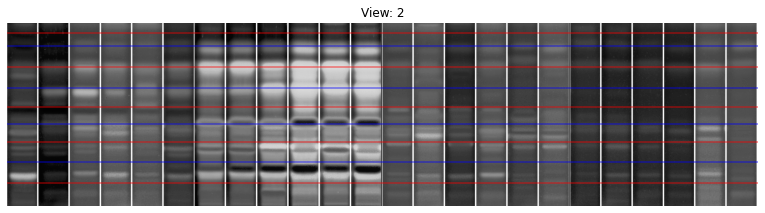

In [67]:
fig = plt.figure(figsize=(30, 15))
for i, img in enumerate(cropped_img_list):
    sub = fig.add_subplot(4, 2, i + 1)
    sub.axis('off')
    sub.imshow(img,cmap='gray')
    for m, val in enumerate(most_useful_features):
        if m % 2 == 0:
            c = 'red'
        else:
            c = 'blue'
        sub.axhline(val,color=c,alpha=.5)
    sub.set_title('View: 2')
    break
plt.tight_layout
fig.subplots_adjust(wspace=.02, hspace=.15)

---
# Union of Intervals Overlapping across All Views 
# !!! USING MEDIAN VALUE IN INERVAL !!!

### Setup for Training on features at Center of Intervals in important features across all Views

#### Remove Warnings

In [68]:
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

#### Combine Important Features from Each View into one long List

In [69]:
# Combine all our View's 'Important Features' and Sort
combined_important_features = np.concatenate(MultiViewOriginalFeaturesInUniqueTrees)
combined_important_features = np.sort(combined_important_features)
print(len(combined_important_features))
print(combined_important_features)

502
[   3    3    6    7    7    8    8    9   10   11   14   14   15   16
   18   21   21   21   21   21   22   22   23   23   23   25   26   27
   29   29   30   33   33   34   34   35   36   46   46   48   50   51
   52   54   63   64   64   64   64   66   68   68   68   69   69   73
   73   75   79   79   79   81   83   86   86   91   92   93   93   93
   95   96  103  105  105  111  112  128  130  136  139  140  140  151
  153  156  160  167  170  170  170  183  191  210  211  211  213  218
  219  219  219  220  221  222  225  226  232  232  236  236  241  249
  253  254  257  265  265  271  273  276  277  279  280  284  291  291
  295  295  295  295  324  324  324  324  333  339  346  347  349  349
  351  351  357  357  358  365  367  369  370  370  370  379  379  384
  384  385  391  391  392  393  398  399  400  401  404  409  409  411
  415  415  415  415  415  417  417  417  432  432  432  435  441  447
  447  447  448  450  454  455  455  456  458  460  463  469  469  470
  

#### Define Interval Extraction for center Feature

In [70]:
# Strictness is how far apart values can be to be considered 'adjacent'
def interval_extract_all_adjacent_values_loose(list, strictness):
    length = len(list)
    i = 0

    res = []

    while (i< length):
        currSeq = []
        while i <length-1 and list[i]+strictness >= list[i + 1]:
            currSeq.append(list[i])
            i += 1
        res.append(currSeq)
        i += 1
    return res

#### Get ends of Intervals

In [71]:
#Get intervals for sorted list of combined important features
all_possible_intervals = interval_extract_all_adjacent_values_loose(combined_important_features,10)

print(len(all_possible_intervals))
# print(all_possible_intervals)

12


In [72]:
#Print length of each interval
lengths_of_intervals = []
for item in all_possible_intervals:
    if len(item) >= 2:
        lengths_of_intervals.append(item[-1]-item[0])
print(lengths_of_intervals)

[108, 12, 19, 85, 93, 88, 78, 96, 105, 109, 54]


#### Get Center of Intervals

In [73]:
#Create array of
    # 1) All individual Values from 'all_possible_intervals' 
    # AND Center of any actual intervals from above array
    # 2) Only Center values from real intervals

centers_and_individual_intervals_of_all_intervals = []
only_centers_of_all_intervals = []

for item in all_possible_intervals:
    if len(item) >= 2:
        # center = int(round( (item[0]+item[1]) / 2, 0))
        medianIndex = len(item) // 2
        center = item[medianIndex]
        only_centers_of_all_intervals.append(center)
        centers_and_individual_intervals_of_all_intervals.append(center)
    else:
        centers_and_individual_intervals_of_all_intervals.append(item[0])

print(len(centers_and_individual_intervals_of_all_intervals))
print(len(only_centers_of_all_intervals))
print(only_centers_of_all_intervals)

12
11
[46, 136, 160, 249, 379, 486, 563, 669, 801, 883, 1000]


#### Append Target Column

In [74]:
# Append final column index to feature arrays which is 
# Target Column from original feature vector

#Get count of Original Features
original_number_of_features = len(multiview_strip_row_avg_list[0][0])

#Append count - 1 to end of new features
# centers_and_individual_intervals_of_all_intervals.append(original_number_of_features-1)
only_centers_of_all_intervals.append(original_number_of_features-1)

In [75]:
print(only_centers_of_all_intervals)

[46, 136, 160, 249, 379, 486, 563, 669, 801, 883, 1000, 1030]


In [76]:
# display(pd.DataFrame(multiview_strip_row_avg_list[0]))

#### Show Features used for Training

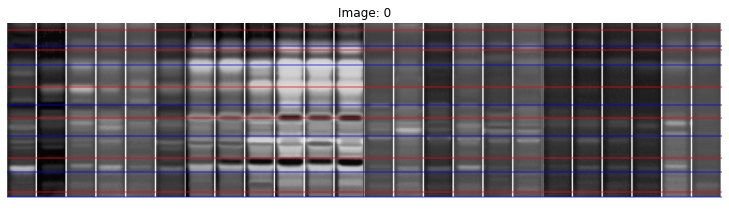

In [77]:
fig = plt.figure(figsize=(30, 15))
for i, img in enumerate(cropped_img_list):
    sub = fig.add_subplot(4, 2, i + 1)
    sub.axis('off')
    sub.imshow(img,cmap='gray')
    for m, val in enumerate(only_centers_of_all_intervals):
        if m % 2 == 0:
            c = 'red'
        else:
            c = 'blue'
        sub.axhline(val,color=c,alpha=.5)
    sub.set_title('Image: '+str(i))
    break
plt.tight_layout
fig.subplots_adjust(wspace=.02, hspace=.15)

#### Train Model

In [78]:
###Train only on features from `only_centers_of_all_intervals`, 
# across different regularizers AND
# on ALL VIEWS

minimized_best_params = []
all_accuracies = []
all_nonzero_weight_cnts = []
regularizers =[.7,.8,.9,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]

only_centers_results_Median = []

for i, strip_row_avg in enumerate(multiview_strip_row_avg_list):

    accuracy = []
    nonzero_weight_cnt = []

    #Convert to Dataframe
    strip_row_avg = pd.DataFrame(strip_row_avg)

    #####
    
    #Get "Useful Features" from Current view using Center of Intervals
    strip_row_avg = strip_row_avg[only_centers_of_all_intervals]

    #####

    #Get Features
    df_feat = strip_row_avg.iloc[:,:-2]

    #Get Targets & Format to 1D vector
    df_target = strip_row_avg.iloc[:,-1:]
    df_target = df_target.values.ravel()

    #Create Model
    model = LinearSVC()

    #Set Model Parameters
    for r_c in regularizers:
        #l1, squared_hinge, dual = False
        model.set_params(random_state=101,
                        verbose=0,
                        max_iter=4500,
                        penalty='l1',
                        loss='squared_hinge',
                        dual=False,
                        tol=2e-3,
                        C=r_c)

        #Train Model
        model.fit(df_feat,df_target)

        #Print Score
        # print("\nStrip "+str(i)+": "+str(model.score(df_feat,df_target).round(3)))
        accuracy.append(round(model.score(df_feat,df_target),3))

        #Append Count of Number of Non-Zero Weights
        nonzero_weight_cnt.append(len(np.unique(pd.DataFrame(np.nonzero(model.coef_)).iloc[1])))
        # print(np.count_nonzero(model.coef_))

    all_accuracies.append(accuracy)
    all_nonzero_weight_cnts.append(nonzero_weight_cnt)

    print('View '+str(i+1))
    results = pd.DataFrame({"Accuracy":accuracy,"Regularizers":regularizers,"Unique Non-Zero Weight Count":nonzero_weight_cnt})
    # display(results)

    #Get index of first 100% Accuracy row
    first_perfect_row_index = results[results.Accuracy==1.0].first_valid_index()
    if first_perfect_row_index:

        #Get row at first_perfect_row_index
        first_perfect_row = pd.DataFrame(results.iloc[first_perfect_row_index])

        #Transpose to row format
        # first_perfect_row = first_perfect_row.transpose()

        #Change index name to match view number
        first_perfect_row = first_perfect_row.rename(columns={first_perfect_row_index:i})

        #Display and Append
        display(first_perfect_row)
        minimized_best_params.append(first_perfect_row)
        
    else:
        #Get index of Max Accuracy Row
        max_acc_row_index = results.idxmax()[0]

        #Get max Accuracy row at above index
        max_acc_row = pd.DataFrame(results.iloc[max_acc_row_index])

        #Change index name to match view number
        max_acc_row = max_acc_row.rename(columns={max_acc_row_index:i})

        #Display and Append
        display(max_acc_row)
        minimized_best_params.append(max_acc_row)

only_centers_results_Median.append(minimized_best_params)

View 1


0
Accuracy                       1.0
Regularizers                  20.0
Unique Non-Zero Weight Count  10.0

View 2


1
Accuracy                       1.0
Regularizers                  11.0
Unique Non-Zero Weight Count   9.0

View 3


2
Accuracy                      0.917
Regularizers                  6.000
Unique Non-Zero Weight Count  7.000

View 4


3
Accuracy                       0.917
Regularizers                  13.000
Unique Non-Zero Weight Count   9.000

View 5


4
Accuracy                       0.833
Regularizers                  12.000
Unique Non-Zero Weight Count  10.000

View 6


5
Accuracy                      0.958
Regularizers                  8.000
Unique Non-Zero Weight Count  7.000

View 7


6
Accuracy                      1.0
Regularizers                  4.0
Unique Non-Zero Weight Count  8.0

View 8


7
Accuracy                      0.958
Regularizers                  8.000
Unique Non-Zero Weight Count  8.000

#### Graph Accuracy vs # of Features Used

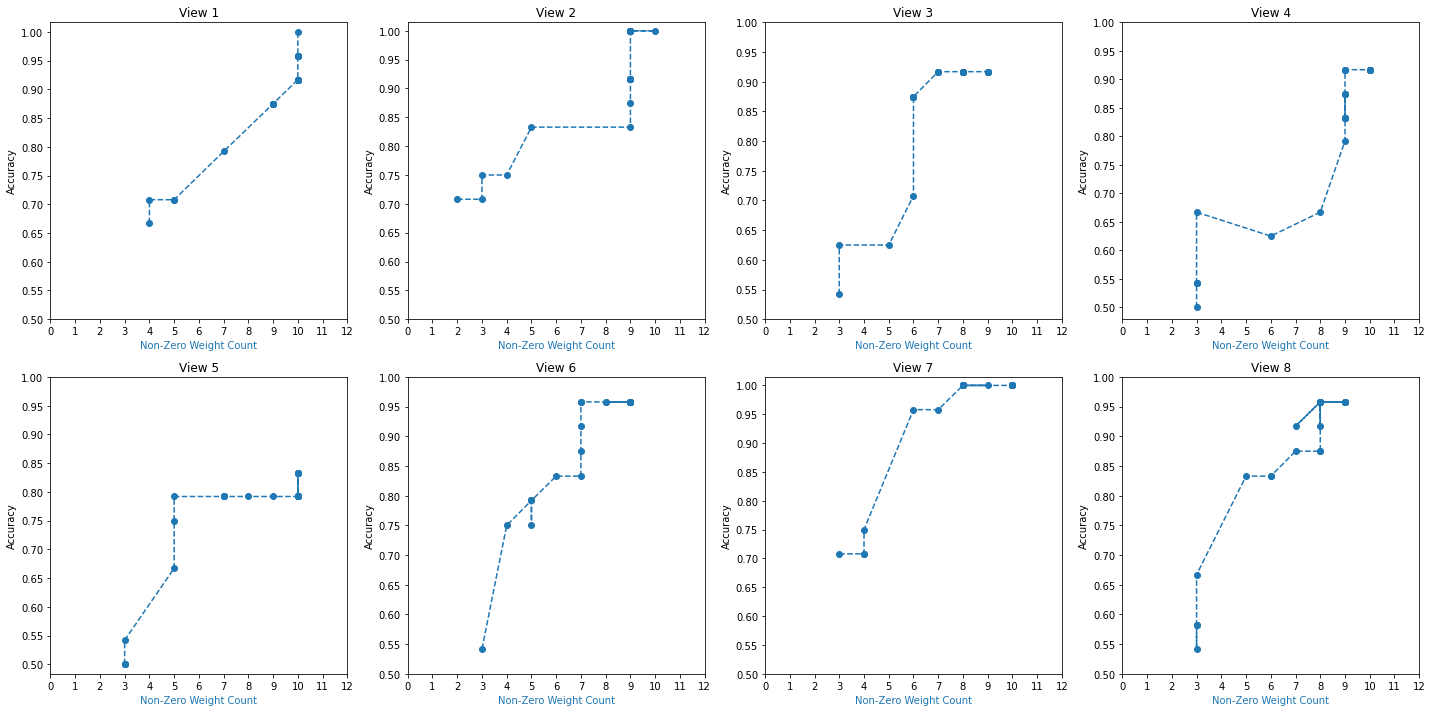

In [79]:
fig=plt.figure(figsize=(20, 10))

for j in range(8):
    #Non-Zero Weight Count Plot
    ax=fig.add_subplot(2, 4, j+1, label="1")

    ax.plot(all_nonzero_weight_cnts[j], all_accuracies[j], marker='o', color="C0", linestyle='dashed')

    ax.set_xlabel("Non-Zero Weight Count", color="C0")
    ax.set_ylabel("Accuracy", color="Black")
    ax.tick_params(axis='x', colors="Black")
    ax.tick_params(axis='y', colors="Black")
    ax.set_yticks([x * 0.05 for x in range(10, 21)])
    ax.set_xticks(np.linspace(0,12,13))

    ax.set_title("View "+str(j+1))

fig.tight_layout()

### Draw Lines at Features used for 100% Classification of View 2
    (Case with Minimum number of Features)

In [80]:
###Train only on features from `centers_and_individual_intervals_of_all_intervals`, 
# across different regularizers on View 3

minimized_best_params = []
all_accuracies = []
all_nonzero_weight_cnts = []

#SET WHICH REGULARIZER TO USE HERE
regularizers =[11]

#SET WHICH VIEW TO USE HERE
strip_row_avg = multiview_strip_row_avg_list[1]

accuracy = []
nonzero_weight_cnt = []

#Convert to Dataframe
strip_row_avg = pd.DataFrame(strip_row_avg)

#####

#Get "Useful Features" from Current view using Center of Intervals
strip_row_avg = strip_row_avg[only_centers_of_all_intervals]

#####

#Get Features
df_feat = strip_row_avg.iloc[:,:-2]

#Get Targets & Format to 1D vector
df_target = strip_row_avg.iloc[:,-1:]
df_target = df_target.values.ravel()

#Create Model
model = LinearSVC()

#Set Model Parameters
for r_c in regularizers:
    #l1, squared_hinge, dual = False
    model.set_params(random_state=101,
                    verbose=0,
                    max_iter=4500,
                    penalty='l1',
                    loss='squared_hinge',
                    dual=False,
                    tol=5e-3,
                    C=r_c)

    #Train Model
    model.fit(df_feat,df_target)

    #Print Score
    # print("\nStrip "+str(i)+": "+str(model.score(df_feat,df_target).round(3)))
    accuracy.append(round(model.score(df_feat,df_target),3))

    #Append Count of Number of Non-Zero Weights
    nonzero_weight_cnt.append(len(np.unique(pd.DataFrame(np.nonzero(model.coef_)).iloc[1])))
    # print(np.count_nonzero(model.coef_))

all_accuracies.append(accuracy)
all_nonzero_weight_cnts.append(nonzero_weight_cnt)

#####
#Get Table of non-zero coefs in model's coef
#   Row 1 holds the row index values in the full coef table
#   Row 2 holds the column index values in the full coef table
model_coefs_nonzero = pd.DataFrame(np.nonzero(model.coef_.copy()))

#Get Array of Unique Columns with at least 1 non-zero value
nonzero_cols = np.unique(model_coefs_nonzero.iloc[1])

print('View '+str(i+1))
results = pd.DataFrame({"Accuracy":accuracy,"Regularizers":regularizers,"Unique Non-Zero Weight Count":nonzero_weight_cnt})
display(results)

View 8


Accuracy  Regularizers  Unique Non-Zero Weight Count
0     0.958            11                             9

In [81]:
#Get Indexes of Columns with at least 1 Non-Zero Value
# (need to change to np.array to do easy index splicing)
nonzero_cols = np.array(nonzero_cols)
centers_and_individual_intervals_of_all_intervals = np.array(centers_and_individual_intervals_of_all_intervals)
most_useful_features = centers_and_individual_intervals_of_all_intervals[nonzero_cols]
print(len(most_useful_features))

9


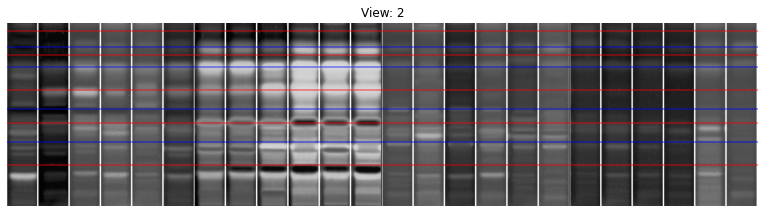

In [82]:
fig = plt.figure(figsize=(30, 15))
for i, img in enumerate(cropped_img_list):
    sub = fig.add_subplot(4, 2, i + 1)
    sub.axis('off')
    sub.imshow(img,cmap='gray')
    for m, val in enumerate(most_useful_features):
        if m % 2 == 0:
            c = 'red'
        else:
            c = 'blue'
        sub.axhline(val,color=c,alpha=.5)
    sub.set_title('View: 2')
    break
plt.tight_layout
fig.subplots_adjust(wspace=.02, hspace=.15)

### Center of Interval vs Median Value

In [83]:
#Transform only_centers_results to proper format
only_centers_results = np.array(only_centers_results).squeeze()
only_centers_results = pd.DataFrame(only_centers_results)
only_centers_results = only_centers_results.rename(columns={0:"Accuracy",1:"Regularizer",2:"Number of Features"})
display(only_centers_results)

Accuracy  Regularizer  Number of Features
0     1.000         19.0                11.0
1     1.000          8.0                 9.0
2     0.875         13.0                 9.0
3     1.000         11.0                 9.0
4     0.917         15.0                10.0
5     1.000         14.0                10.0
6     1.000          5.0                11.0
7     0.958         16.0                11.0

In [84]:
#Transform only_centers_results to proper format
only_centers_results_Median = np.array(only_centers_results_Median).squeeze()
only_centers_results_Median = pd.DataFrame(only_centers_results_Median)
only_centers_results_Median = only_centers_results_Median.rename(columns={0:"Accuracy",1:"Regularizer",2:"Number of Features"})
display(only_centers_results_Median)

Accuracy  Regularizer  Number of Features
0     1.000         20.0                10.0
1     1.000         11.0                 9.0
2     0.917          6.0                 7.0
3     0.917         13.0                 9.0
4     0.833         12.0                10.0
5     0.958          8.0                 7.0
6     1.000          4.0                 8.0
7     0.958          8.0                 8.0

In [85]:
min_params_comparison = pd.concat([only_centers_results,only_centers_results_Median],axis=1)

In [86]:
display(min_params_comparison)

Accuracy  Regularizer  Number of Features  Accuracy  Regularizer  \
0     1.000         19.0                11.0     1.000         20.0   
1     1.000          8.0                 9.0     1.000         11.0   
2     0.875         13.0                 9.0     0.917          6.0   
3     1.000         11.0                 9.0     0.917         13.0   
4     0.917         15.0                10.0     0.833         12.0   
5     1.000         14.0                10.0     0.958          8.0   
6     1.000          5.0                11.0     1.000          4.0   
7     0.958         16.0                11.0     0.958          8.0   

   Number of Features  
0                10.0  
1                 9.0  
2                 7.0  
3                 9.0  
4                10.0  
5                 7.0  
6                 8.0  
7                 8.0

In [87]:
print(np.shape(only_centers_results))
# print(only_centers_results)
print(only_centers_results["Accuracy"][0])

(8, 3)
1.0


In [88]:
tot = 0
for row in only_centers_results["Accuracy"]:
    tot += row
    # print(row)
print("Average Accuracy for Center of Interval Method: "+str(tot/len(only_centers_results)))

tot = 0
for row in only_centers_results_Median["Accuracy"]:
    tot += row
    # print(row)
print("Average Accuracy for Median of Interval Method: "+str(tot/len(only_centers_results)))

Average Accuracy for Center of Interval Method: 0.96875
Average Accuracy for Median of Interval Method: 0.947875


##### Conclusion:
    Though the two methods for choosing a 'center' of the interval did surpass each other in accuracy on some views, generally, the strategy to just take the Center Value between the ends of the interval averaged a higher accuracy